# Importing Libraries & Data

In [94]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats.mstats as ssm
from scipy.stats import gaussian_kde as kde
import random


In [95]:
rawData=pd.read_csv('CrowdstormingDataJuly1st.csv')

# Visualizing rawData

In [96]:
rawData.ix[:10,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0


The definition of all the "column values" are described in DATA.md but let screen them here also: 

In [97]:
rawData.ix[:10,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,0,0,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,0,0,0,36499.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


# Tests

In [98]:
list(rawData.columns.values)

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

In [99]:
R=rawData[rawData['player'] == 'Philipp Lahm']
R.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
1806,philipp-lahm,Philipp Lahm,Bayern München,Germany,11.11.1983,170.0,66.0,Left Fullback,2,2,...,0.25,72,28,IRL,0.355498,4078.0,0.000098,0.517225,4238.0,0.000405
2935,philipp-lahm,Philipp Lahm,Bayern München,Germany,11.11.1983,170.0,66.0,Left Fullback,4,1,...,0.25,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3748,philipp-lahm,Philipp Lahm,Bayern München,Germany,11.11.1983,170.0,66.0,Left Fullback,2,1,...,0.25,100,50,MKD,0.327139,170.0,0.002362,0.959538,173.0,0.014794
4165,philipp-lahm,Philipp Lahm,Bayern München,Germany,11.11.1983,170.0,66.0,Left Fullback,1,1,...,0.25,113,52,RUS,0.398174,526.0,0.000809,1.212727,550.0,0.004521
5276,philipp-lahm,Philipp Lahm,Bayern München,Germany,11.11.1983,170.0,66.0,Left Fullback,1,1,...,0.25,131,27,ROU,0.385082,537.0,0.000756,0.859431,562.0,0.003620


In [100]:
R=R[R['games']>=40]
R

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
48893,philipp-lahm,Philipp Lahm,Bayern München,Germany,11.11.1983,170.0,66.0,Left Fullback,47,29,...,0.25,933,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
136419,philipp-lahm,Philipp Lahm,Bayern München,Germany,11.11.1983,170.0,66.0,Left Fullback,40,24,...,0.25,2902,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225


# Analyzing Data

After looking at the data, we realized that some referees had less than 22 Dayds which is technically impossible since at every game each referee receive at least 22 Dyads. So we decied to remove the referees with less than 22 Dyads

In [101]:
rawData.sort_values('refNum');
allRefs = len(rawData.refNum.value_counts())
allDyads = np.sum(rawData.games)

specRef=rawData
for i in range(allRefs):
    specRef1=specRef[specRef['refNum']==i] #we put dataframe of each referee into specRef1 as a temporary variable
    if(np.sum(specRef1['games'])<22):
        specRef=specRef.drop(specRef1.index)

In [102]:
specRef.head()  #specRef is now containing the new DataFrame without the referees with less than 22 Dyads, corresponding to one game as a referee.
specRef=specRef.reset_index(drop=True)  #To reset the index of the Dataframe

Now let's study the two parameters 'rater1' and 'rater2' to see their robustness to define if a player is "black" or "white". And to do so, lets visualize the two raters first.

In [103]:
specRef.ix[:30,17:19]

,rater1,rater2
0,0.25,0.00
1,0.00,0.25
2,1.00,1.00
3,0.25,0.25
4,0.00,0.00
5,0.00,0.00
6,0.50,0.50
7,0.00,0.00
8,0.00,0.00
9,0.00,0.25


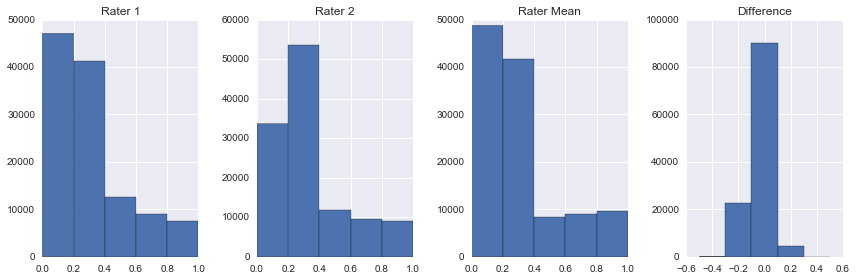

In [104]:
fig, ax = plt.subplots(1,4,figsize=(12, 4))
c = sns.color_palette()
ax[0].hist(specRef['rater1'].dropna().tolist(),bins = 5, range = (0,1), color = c[0])
ax[0].set_title('Rater 1')
ax[1].hist(specRef['rater2'].dropna().tolist(),bins = 5, range = (0,1), color = c[0])
ax[1].set_title('Rater 2')
ax[2].hist(((specRef['rater1']+specRef['rater2'])/2).dropna().tolist(),bins = 5, range = (0,1), color = c[0])
ax[2].set_title('Rater Mean')
ax[3].hist((specRef['rater1']-specRef['rater2']).dropna().tolist(),bins = 5, range = (-0.5,0.5), color = c[0])
ax[3].set_title('Difference')

fig.tight_layout()

We can see that the diffeence the two parameters, is in general low. We can then conclude that this parameters can be used to define if a person if of a white skin color or black skin color.

Preparation Train/Test Dataframe

Machine Learning: Output skin color with a certain matrix!

In [145]:
#Add column with average
specRef=specRef.assign(Mean=(specRef['rater1']+specRef['rater2'])/2)
specRef.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Mean
0,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
1,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
2,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000
3,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250
4,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000


In [147]:
specRef=specRef.assign(SkinColor=np.random.randn(len(specRef)))

for i in range(len(specRef)):
    if (specRef.iloc[i,28]<0.375):
        specRef.iloc[i,29]='white'
    elif(specRef.iloc[i,28]>0.675):
        specRef.iloc[i,29]='black'
    else:
        specRef.iloc[i,29]=np.nan
        
specRef.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Mean,SkinColor
0,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,white
1,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,white
2,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,black
3,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,white
4,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white


In [151]:
newSpecRef=specRef.dropna(subset=['SkinColor'])

In [150]:
specRef

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Mean,SkinColor
0,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,white
1,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,white
2,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,black
3,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,white
4,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white
5,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white
6,ashkan-dejagah,Ashkan Dejagah,Fulham FC,England,05.07.1986,181.0,74.0,Left Winger,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.500,NaN
7,benedikt-hoewedes,Benedikt Höwedes,FC Schalke 04,Germany,29.02.1988,187.0,80.0,Center Back,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white
8,chris-baird,Chris Baird,Fulham FC,England,25.02.1982,186.0,77.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white
10,daniel-schwaab,Daniel Schwaab,Bayer Leverkusen,Germany,23.08.1988,186.0,76.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white


As we can see, by removing the mean of the rater which are included in between 0.375 and 0.625 we loose 15k dyads. So approximately 12% of the data.

Test/Train

In [172]:
indexes = np.random.rand(len(newSpecRef)) < 0.8
train = newSpecRef[indexes]
test = newSpecRef[~indexes]
test

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Mean,SkinColor
3,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,white
15,jan-moravek,Jan Morávek,FC Augsburg,Germany,01.11.1989,180.0,75.0,Attacking Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,white
23,nemanja-vidic,Nemanja Vidić,Manchester United,England,21.10.1981,188.0,82.0,Center Back,2,2,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white
25,patrick-ebert,Patrick Ebert,Real Valladolid,Spain,17.03.1987,172.0,68.0,Left Midfielder,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white
26,peter-gulacsi,Péter Gulácsi,Liverpool FC (R),England,06.05.1990,190.0,75.0,Goalkeeper,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white
27,steven-davis_2,Steven Davis,Southampton FC,England,01.01.1985,170.0,60.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white
39,andre-ayew,André Ayew,Olympique Marseille,France,17.12.1989,176.0,72.0,Attacking Midfielder,1,1,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,0.750,black
54,bocoundji-ca,Bocoundji Cá,Stade Reims,France,28.12.1986,172.0,69.0,Defensive Midfielder,5,2,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,0.750,black
86,franck-signorino,Franck Signorino,Stade Reims,France,19.09.1981,173.0,69.0,Left Fullback,2,2,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,0.000,white
104,henri-saivet,Henri Saivet,Girondins Bordeaux,France,26.10.1990,174.0,73.0,Right Winger,1,1,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,1.000,black


In [199]:
y=train['SkinColor']
ytest=test['SkinColor']

In [200]:
X=train[['height', 'weight']]

In [222]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [223]:
Xtest=test[['height', 'weight']]
ypredict=knn.predict(Xtest)

In [224]:
print(metrics.accuracy_score(ytest, ypredict))

0.861681251657
